# Imports

In [1]:
import os
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, Normalizer, QuantileTransformer

In [2]:
# Carregando as configurações do arquivo 'config_modelo.json'
configs = json.load(open('config_modelo.json', 'r'))

In [3]:
# Criar a pasta 'save_dir' caso não exista no diretório
if not os.path.exists(configs['model']['save_dir']):
            os.makedirs(configs['model']['save_dir'])

In [4]:
# Carregar o Dataset
filepath = 'C:/Users/auW10/Documents/CodigosDoAu/000_Doutorado/dataset/'
df = pd.read_pickle(filepath+'dataset_with_TI_ciclo1_multiclass_jupyter_aug_dim_53TIs.pkl')
print(df.shape)
df.head(2)

(139881, 71)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_5_CLOSE,EMA_10_CLOSE,...,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,TARGET_WIN_CAT_ENC,HOLD,SELL,BUY
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53462.598377,53394.139577,...,11,2,2,15.0,HOLD,2,1,1,0,0
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53446.732251,53397.932381,...,11,2,2,50.0,HOLD,2,1,1,0,0


## Split dos Dados

In [6]:
df.columns.tolist()
df.columns.array

<PandasArray>
[             'DATETIME',                  'DATE',                  'TIME',
                  'OPEN',                  'HIGH',                   'LOW',
                 'CLOSE',                   'VOL',           'EMA_5_CLOSE',
          'EMA_10_CLOSE',          'EMA_20_CLOSE',            'EMA_5_OPEN',
           'EMA_10_OPEN',           'EMA_20_OPEN',            'EMA_5_HIGH',
           'EMA_10_HIGH',           'EMA_20_HIGH',             'EMA_5_LOW',
            'EMA_10_LOW',            'EMA_20_LOW',                'KAMA_5',
               'KAMA_10',               'KAMA_20',            'MIDPOINT_3',
           'MIDPOINT_12',            'MIDPRICE_3',           'MIDPRICE_12',
               'TRIMA_5',              'TRIMA_10',              'TRIMA_20',
                 'ADX_3',                 'ADX_6',                'ADX_10',
                   'BOP',                 'MOM_3',                 'MOM_6',
                'MOM_10',                'MOM_14',                 'ROC_3'

In [7]:
print(df.shape)
df2 = df.drop([  'MES',
                 'DIA_SEMANA', 
                 'TARGET_WIN',   
                 'TARGET_WIN_CAT_ENC',
                 'HOLD',
                 'SELL',
                 'BUY'
            
              ], axis=1)
print(df2.shape)
df2.head(2)

(139881, 71)
(139881, 64)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_5_CLOSE,EMA_10_CLOSE,...,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,HORA_NOBRE,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53462.598377,53394.139577,...,224.882410,16995.0,183.08836,157.567344,133.163314,122.7500,160.0,2,HOLD,2
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53446.732251,53397.932381,...,-968.557883,24029.0,190.39224,165.472787,139.149704,126.8625,205.0,2,HOLD,2


In [8]:
df3 = df2[df2['DATETIME'].dt.year < 2020]
df3.drop(['DATE', 'TIME'], axis=1, inplace=True)
df4 = df3[df3['DATETIME'].dt.year > 2014].reset_index(drop=True)
df4

C:\Users\auW10\Anaconda3\envs\phd\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,DATETIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_5_CLOSE,EMA_10_CLOSE,EMA_20_CLOSE,EMA_5_OPEN,...,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,HORA_NOBRE,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL
0,2015-01-02 09:00:00,50200.0,50400.0,50165.0,50275.0,861.0,50325.205919,50381.098425,50504.834778,50310.326119,...,-1281.593817,-165899.0,118.566120,105.950934,106.052199,107.965299,235.0,0,HOLD,2
1,2015-01-02 09:05:00,50275.0,50370.0,50185.0,50335.0,968.0,50328.470612,50372.716893,50488.660037,50298.550746,...,-915.986039,-164931.0,140.710746,119.125779,112.631182,111.817034,185.0,0,HOLD,2
2,2015-01-02 09:10:00,50335.0,50340.0,50205.0,50285.0,825.0,50313.980408,50356.768367,50469.263843,50310.700497,...,-637.960745,-165756.0,138.807164,121.771482,114.495250,112.976182,135.0,0,HOLD,2
3,2015-01-02 09:15:00,50300.0,50315.0,50215.0,50280.0,406.0,50302.653605,50342.810482,50451.238715,50307.133665,...,-429.099218,-166162.0,125.871443,118.142902,113.287313,112.327373,100.0,0,SELL,1
4,2015-01-02 09:20:00,50265.0,50280.0,50175.0,50190.0,958.0,50265.102404,50315.026758,50426.358837,50293.089110,...,-544.595225,-167120.0,118.914295,115.952418,112.596703,111.961004,105.0,0,SELL,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132938,2019-12-30 17:45:00,116245.0,116310.0,116155.0,116185.0,56195.0,116340.624588,116429.656185,116502.191830,116419.865436,...,-57793.952461,-7927844.0,179.921938,145.712683,126.369144,125.228206,155.0,2,SELL,1
132939,2019-12-30 17:50:00,116185.0,116265.0,116060.0,116105.0,60633.0,116262.083059,116370.627788,116464.364037,116341.576958,...,-72510.139626,-7988477.0,188.281292,155.593903,132.921715,129.216796,205.0,2,SELL,1
132940,2019-12-30 17:55:00,116105.0,116140.0,115875.0,115975.0,72789.0,116166.388706,116298.695463,116417.757938,116262.717972,...,-79338.713875,-8061266.0,213.854195,173.828252,143.928239,136.005956,265.0,2,BUY,0
132941,2019-12-30 18:00:00,115985.0,116020.0,115850.0,115925.0,43625.0,116085.925804,116230.750833,116370.828611,116170.145315,...,-77901.331778,-8104891.0,199.236130,173.190210,146.100886,137.705658,170.0,2,BUY,0


In [9]:
df_train = df2[(df2['DATETIME'] >= '2015-01-01') & (df2['DATETIME'] < '2018-01-01')]
#df_train = df2[(df2['DATETIME'] >= '2017-12-01') & (df2['DATETIME'] < '2019-07-01')]
#df_train = df_train.iloc[-10000:, :]

#----------------------------------------------------------------------------------------------------

df_valid = df2[(df2['DATETIME'] >= '2018-01-01') & (df2['DATETIME'] < '2019-01-01')]
#df_valid = df2[(df2['DATETIME'] >= '2019-07-01') & (df2['DATETIME'] < '2020-03-01')]
#df_valid = df_valid.iloc[:6600, :]

#----------------------------------------------------------------------------------------------------

df_test  = df2[(df2['DATETIME'] >= '2019-01-01') & (df2['DATETIME'] < '2020-01-01')]
#df_test  = df2[(df2['DATETIME'] >= '2020-01-01')]

#df_test  = df2[(df2['DATETIME'] < '2017-12-01')]
#df_test = df_test.iloc[:500,:]

#----------------------------------------------------------------------------------------------------

print('Proporção Train: {:.1%} | Validation: {:.1%} | Test: {:.1%}'.format(
                                            df_train['DATETIME'].count()/df2['DATETIME'].count(),
                                            df_valid['DATETIME'].count()/df2['DATETIME'].count(),
                                            df_test['DATETIME'].count()/df2['DATETIME'].count()))

df_train.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
df_valid.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
df_test.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
print(df_train.shape, df_valid.shape, df_test.shape)

Proporção Train: 57.0% | Validation: 18.9% | Test: 19.1%
(79795, 61) (26410, 61) (26738, 61)


C:\Users\auW10\Anaconda3\envs\phd\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
df_test.iloc[19:200].head(1)

,OPEN,HIGH,LOW,CLOSE,VOL,EMA_5_CLOSE,EMA_10_CLOSE,EMA_20_CLOSE,EMA_5_OPEN,EMA_10_OPEN,...,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,HORA_NOBRE,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL
109098,88095.0,88185.0,88035.0,88150.0,28664.0,88120.485588,88090.757497,88085.21074,88103.571694,88074.762323,...,28633.191133,-3220019.0,140.147904,138.857426,142.408421,142.348568,150.0,1,BUY,0


In [11]:
df_train['TARGET_WIN_CAT3'].value_counts()

HOLD    65556
SELL     7212
BUY      7027
Name: TARGET_WIN_CAT3, dtype: int64

In [12]:
df_train['TARGET_WIN_CAT3'].value_counts()[0]

65556

In [13]:
hold_train = df_train['TARGET_WIN_CAT3_LABEL'].value_counts()[2]
hold_valid = df_valid['TARGET_WIN_CAT3_LABEL'].value_counts()[2]
hold_test = df_test['TARGET_WIN_CAT3_LABEL'].value_counts()[2]

print('\nDados Categóricos de Treino -- BUY: %d | SELL: %d | HOLD: %d' % (df_train['TARGET_WIN_CAT3_LABEL'].value_counts()[0], df_train['TARGET_WIN_CAT3_LABEL'].value_counts()[1], hold_train))
print('\nDados Categóricos de Validação -- BUY: %d | SELL: %d | HOLD: %d' % (df_valid['TARGET_WIN_CAT3_LABEL'].value_counts()[0], df_valid['TARGET_WIN_CAT3_LABEL'].value_counts()[1], hold_valid))
print('\nDados Categóricos de Teste -- BUY: %d | SELL: %d | HOLD: %d' % (df_test['TARGET_WIN_CAT3_LABEL'].value_counts()[0], df_test['TARGET_WIN_CAT3_LABEL'].value_counts()[1], hold_test))



Dados Categóricos de Treino -- BUY: 7027 | SELL: 7212 | HOLD: 65556

Dados Categóricos de Validação -- BUY: 4212 | SELL: 4272 | HOLD: 17926

Dados Categóricos de Teste -- BUY: 4192 | SELL: 3950 | HOLD: 18596


In [14]:
buy_train = df_train.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[4]
sell_train = df_train.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[5]
hold_train = df_train.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[3]

buy_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[4]
sell_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[5]
hold_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[3]

buy_test = df_test.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[4]
sell_test = df_test.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[5]
hold_test = df_test.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3_LABEL'].value_counts()[3]

print('\nDados Categóricos de Treino Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_train, sell_train, hold_train))
print('\nDados Categóricos de Validação Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_valid, sell_valid, hold_valid))
print('\nDados Categóricos de Teste Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_test, sell_test, hold_test))



Dados Categóricos de Treino Hora Nobre -- BUY: 2706 | SELL: 2505 | HOLD: 16928

Dados Categóricos de Validação Hora Nobre -- BUY: 1433 | SELL: 1372 | HOLD: 4515

Dados Categóricos de Teste Hora Nobre -- BUY: 1496 | SELL: 1462 | HOLD: 4452


In [15]:
df_train.groupby(['HORA_NOBRE'])['TARGET_WIN_CAT3'].value_counts()

HORA_NOBRE  TARGET_WIN_CAT3
0           HOLD                3765
            BUY                  340
            SELL                 323
1           HOLD               16928
            SELL                2706
            BUY                 2505
2           HOLD               44863
            SELL                4183
            BUY                 4182
Name: TARGET_WIN_CAT3, dtype: int64

In [16]:
np.random.seed(2345)
porcentagem_selecao_train = (buy_train / hold_train)
amostra_train = np.random.choice( a=[0,1], size=hold_train, replace=True, 
                                   p=[1-porcentagem_selecao_train, porcentagem_selecao_train] )
print(len(amostra_train))
print(len(amostra_train[amostra_train == 1]))
print(len(amostra_train[amostra_train == 0]))

16928
2709
14219


In [17]:
np.random.seed(2345)
porcentagem_selecao_valid = (buy_valid / hold_valid)
amostra_valid = np.random.choice( a=[0,1], size=hold_valid, replace=True, 
                                   p=[1-porcentagem_selecao_valid, porcentagem_selecao_valid] )
print(len(amostra_valid))
print(len(amostra_valid[amostra_valid == 1]))
print(len(amostra_valid[amostra_valid == 0]))

4515
1459
3056


In [18]:
np.random.seed(2345)
porcentagem_selecao_test = (buy_test / hold_test)
amostra_test = np.random.choice( a=[0,1], size=hold_test, replace=True, 
                                   p=[1-porcentagem_selecao_test, porcentagem_selecao_test] )
print(len(amostra_test))
print(len(amostra_test[amostra_test == 1]))
print(len(amostra_test[amostra_test == 0]))

4452
1520
2932


In [19]:
def normalize(data):

    scaler_x = StandardScaler()

    x = data.iloc[:, :-3]
    x = scaler_x.fit_transform(x) 

    y = data.iloc[:,-2]
    y_list = np.array(y.to_list())

    return x, y_list

In [20]:
def get_train_valid_test_data(seq_len, df, amostragem):
    print('df.shape: ', df.shape)
    a=0
    for i in range(len(df) - seq_len):
        if df['TARGET_WIN_CAT3'][i+seq_len-1] == 'HOLD':
            if amostragem[a] == 0:
                df.drop((i+seq_len-1), axis=0, inplace=True) 
            a+=1

    x, y = normalize(df)

    return x, y

In [21]:
def next_window(i, seq_len, df):
    df = df[i:i+seq_len]
    scaler_x = StandardScaler()
    
    x = df.iloc[:, :-3]
    x = scaler_x.fit_transform(x) 
    
    y = df.iloc[-1,-2]
    # y_list = np.array(y.to_list())
    
    return x, y

In [22]:
def get_train_valid_test_data_Slide_Window(seq_len, df, amostragem):
    print('df.shape: ', df.shape)
    a=0
    data_x = []
    data_y = []
    for i in range(len(df) - seq_len):
        if df['TARGET_WIN_CAT3'].iloc[i+seq_len] == 'HOLD':
            if amostragem[a] == 1:    
                x, y = next_window(i, seq_len, df)
                data_x.append(x)
                data_y.append(y)
            a+=1
        else:
            x, y = next_window(i, seq_len, df)
            data_x.append(x)
            data_y.append(y)

    return np.array(data_x), np.array(data_y)

In [23]:
df_train_reset_index = df_train[df_train['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_train, y_train = get_train_valid_test_data(seq_len=1, 
                                             df=df_train_reset_index, 
                                             amostragem=amostra_train)
print('x_train: ', x_train.shape,' | y_train: ', y_train.shape)

df.shape:  (22139, 61)
x_train:  (7921, 58)  | y_train:  (7921,)


In [24]:
df_train_reset_index = df_train[df_train['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_train_sw, y_train_sw = get_train_valid_test_data_Slide_Window( seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_train_reset_index, 
                                                                 amostragem=amostra_train)
print('x_train_sw: ', x_train_sw.shape,' | y_train_sw: ', y_train_sw.shape)

df.shape:  (22139, 61)
x_train_sw:  (7907, 50, 58)  | y_train_sw:  (7907,)


In [25]:
print(len(x_train), len(y_train))
print(len(x_train_sw), len(y_train_sw))

7921 7921
7907 7907


In [26]:
df_valid_reset_index = df_valid[df_valid['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_valid, y_valid = get_train_valid_test_data(seq_len=1, 
                                             df=df_valid_reset_index, 
                                             amostragem=amostra_valid)
print(x_valid.shape, y_valid.shape)

df.shape:  (7320, 61)
(4265, 58) (4265,)


In [27]:
df_valid_reset_index = df_valid[df_valid['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_valid_sw, y_valid_sw = get_train_valid_test_data_Slide_Window( seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_valid_reset_index, 
                                                                 amostragem=amostra_valid)
print(x_valid_sw.shape, y_valid_sw.shape)

df.shape:  (7320, 61)
(4237, 50, 58) (4237,)


In [28]:
df_test_reset_index = df_test[df_test['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_test, y_test = get_train_valid_test_data(seq_len=1, 
                                             df=df_test_reset_index, 
                                             amostragem=amostra_test)
print(x_test.shape, y_test.shape)

df.shape:  (7410, 61)
(4478, 58) (4478,)


In [29]:
df_test_reset_index = df_test[df_test['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_test_sw, y_test_sw = get_train_valid_test_data_Slide_Window(   seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_test_reset_index, 
                                                                 amostragem=amostra_test)
print(x_test_sw.shape, y_test_sw.shape)

df.shape:  (7410, 61)
(4444, 50, 58) (4444,)


In [30]:
print(len(x_train), len(y_train))
print(len(x_train_sw), len(y_train_sw))

7921 7921
7907 7907


In [31]:
x_train

array([[-0.80337707, -0.80806519, -0.80634505, ..., -0.36642424,
        -0.25745841, -0.20950467],
       [-0.79754225, -0.80329114, -0.79785783, ..., -0.51862625,
        -0.36418169, -0.6457033 ],
       [-0.80602926, -0.81124789, -0.80846685, ..., -0.33633955,
        -0.25038293, -0.33413285],
       ...,
       [ 2.04295617,  2.03832969,  2.04854292, ..., -1.55555246,
        -1.50364194, -1.2065301 ],
       [ 2.04083442,  2.03726879,  2.04642111, ..., -1.64399092,
        -1.59501906, -1.08190192],
       [ 2.04295617,  2.03779924,  2.04801247, ..., -1.74727228,
        -1.68916044, -1.2065301 ]])

In [32]:
x_train_sw

array([[[ 0.83688569,  0.82291584,  0.87564623, ..., -0.59391925,
         -0.61785376, -1.10971587],
        [ 0.86294067,  0.83874317,  0.8654203 , ..., -0.7035151 ,
         -0.70322108, -0.74706362],
        [ 0.81083072,  0.78598539,  0.79895177, ..., -0.75796622,
         -0.74882108, -0.52947228],
        ...,
        [-1.08076023, -1.13967354, -1.03148938, ...,  0.41373998,
          0.77206313, -1.03718542],
        [-1.08597122, -1.14494932, -1.07239309, ...,  0.26618428,
          0.65269892, -0.52947228],
        [-1.11723719, -1.12912198, -1.03660234, ...,  0.06957588,
          0.49197098, -0.81959407]],

       [[ 1.17268566,  1.18036174,  1.20581067, ..., -0.84334394,
         -0.90475888, -0.75526242],
        [ 1.18813335,  1.2166678 ,  1.2311407 , ..., -0.91057743,
         -0.96107766, -0.61085278],
        [ 1.22417796,  1.18554832,  1.20581067, ..., -0.98799667,
         -1.02680682, -0.6830576 ],
        ...,
        [-0.96939405, -1.01874793, -0.93710973, ..., -

## Cálculo do Weighted F Score

In [33]:
def weightedFScore(confusion_matrix):
    beta_1 = math.pow(0.5, 2)
    beta_2 = math.pow(0.25, 2)
    beta_3 = math.pow(0.125, 2)
    
    num_tu = confusion_matrix[[0],[0]]
    num_tf = confusion_matrix[[1],[1]]
    num_td = confusion_matrix[[2],[2]]
    
    wrongU_trueD = confusion_matrix[[2],[0]]
    wrongD_trueU = confusion_matrix[[0],[2]]
    wrongU_trueF = confusion_matrix[[1],[0]]
    wrongD_trueF = confusion_matrix[[1],[2]]
    wrongF_trueU = confusion_matrix[[0],[1]]
    wrongF_trueD = confusion_matrix[[2],[1]]
    
    num_tp = num_tu + num_td + (beta_3 * num_tf)
    erro_tipo_1 = wrongU_trueD + wrongD_trueU
    erro_tipo_2 = wrongU_trueF + wrongD_trueF
    erro_tipo_3 = wrongF_trueU + wrongF_trueD
    
    num = (1 + beta_1 + beta_2) * num_tp
    den = num + erro_tipo_1 + (beta_1 * erro_tipo_2) + (beta_2 * erro_tipo_3)
    
    wFScore = num / den
    
    return wFScore

# Modelos

In [34]:
import lightgbm as lgbm
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## LightGBM

In [29]:
model_lgbm = lgbm.LGBMClassifier(n_jobs=-1, random_state=0, n_estimators=5000, learning_rate=0.001, num_leaves=2**6,
                                 subsample=0.9, subsample_freq=1, colsample_bytree=1.)

model_lgbm.fit(x_train, y_train)
predict_lgbm = model_lgbm.predict(x_test)

accuracy_score_LGBM = accuracy_score(y_test, predict_lgbm)

print('Accuracy Score - LightGBM: ', accuracy_score_LGBM)
print(classification_report(y_test, predict_lgbm))

Accuracy Score - LightGBM:  0.3981179181870559
              precision    recall  f1-score   support

         BUY       0.37      0.39      0.38      1746
        HOLD       0.44      0.48      0.46      1757
        SELL       0.38      0.32      0.35      1704

    accuracy                           0.40      5207
   macro avg       0.40      0.40      0.40      5207
weighted avg       0.40      0.40      0.40      5207



In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predict_lgbm, labels=["BUY", "SELL", "HOLD"])
confusion_matrix

array([[680, 505, 561],
       [663, 552, 489],
       [516, 400, 841]], dtype=int64)

In [31]:
weightedFScore_LGBM = weightedFScore(confusion_matrix)[0] 
weightedFScore_LGBM

0.5277089376661241

<AxesSubplot:>

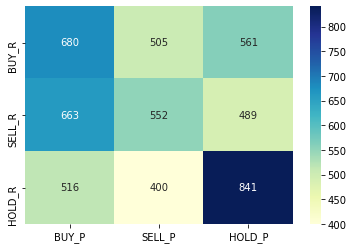

In [32]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_LGBM = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_LGBM, annot=True, fmt='d', cmap='YlGnBu')

### Compare train and test set accuracy

In [33]:
#y_pred_train = model_lgbm.predict(x_train)
#print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

### Check for Overfitting

In [34]:
# print the scores on training and test set

#print('Training set score: {:.4f}'.format(model_lgbm.score(x_train, y_train)))

#print('Test set score: {:.4f}'.format(model_lgbm.score(x_test, y_test)))

In [35]:
#print('Validation set score: {:.4f}'.format(model_lgbm.score(x_valid, y_valid)))

## Random Forest

In [36]:
model_randomF = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=5000)
model_randomF.fit(x_train, y_train)
predict_randomF = model_randomF.predict(x_test)

accuracy_score_RF = accuracy_score(y_test, predict_randomF)
print('Accuracy Score - Random Forest: ', accuracy_score_RF)

Accuracy Score - Random Forest:  0.39734972152871134


In [37]:
print(classification_report(y_test, predict_randomF))

              precision    recall  f1-score   support

         BUY       0.37      0.31      0.34      1746
        HOLD       0.43      0.53      0.47      1757
        SELL       0.38      0.35      0.36      1704

    accuracy                           0.40      5207
   macro avg       0.39      0.40      0.39      5207
weighted avg       0.39      0.40      0.39      5207



In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predict_randomF, labels=["BUY", "SELL", "HOLD"])
confusion_matrix

array([[547, 569, 630],
       [504, 596, 604],
       [422, 409, 926]], dtype=int64)

In [39]:
weightedFScore_RF = weightedFScore(confusion_matrix)[0] 
weightedFScore_RF

0.5280326343079771

<AxesSubplot:>

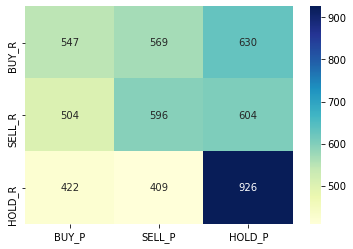

In [40]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_RF = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_RF, annot=True, fmt='d', cmap='YlGnBu')

### Compare train and test set accuracy

In [41]:
#y_pred_train = model_randomF.predict(x_train)
#print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

### Check for Overfitting

In [42]:
# print the scores on training and test set

#print('Training set score: {:.4f}'.format(model_randomF.score(x_train, y_train)))

#print('Test set score: {:.4f}'.format(model_randomF.score(x_test, y_test)))

In [43]:
#print('Validation set score: {:.4f}'.format(model_randomF.score(x_valid, y_valid)))

# Deep Learning

In [220]:
'''
# Encoding categorical data
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

labelencoder_Y_1 = LabelEncoder()
yy = labelencoder_Y_1.fit_transform(y_train)
y_train2 = to_categorical(yy)

labelencoder_Y_1 = LabelEncoder()
yy = labelencoder_Y_1.fit_transform(y_test)
y_test2 = to_categorical(yy)

labelencoder_Y_1 = LabelEncoder()
yy = labelencoder_Y_1.fit_transform(y_valid)
y_valid2 = to_categorical(yy)

print(y_train[10:20])
print(y_train2[10:20])

print(y_test[10:20])
print(y_test2[10:20])

print(y_valid[10:20])
print(y_valid2[10:20])

# BUY | SELL | HOLD
'''

['SELL' 'SELL' 'SELL' 'BUY' 'SELL' 'HOLD' 'BUY' 'HOLD' 'HOLD' 'SELL']
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
['BUY' 'BUY' 'HOLD' 'SELL' 'HOLD' 'BUY' 'HOLD' 'BUY' 'BUY' 'HOLD']
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
['HOLD' 'BUY' 'SELL' 'HOLD' 'HOLD' 'HOLD' 'HOLD' 'BUY' 'HOLD' 'SELL']
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
4265


In [86]:
# Encoding categorical data
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def encode_categ_data(data):
    labelencoder = LabelEncoder()
    x = labelencoder.fit_transform(data)
    data_encoded = to_categorical(x)
    
    #print(data[10:20])
    #print(data_encoded[10:20])
    
    return data_encoded

In [36]:
# example of training a final classification model
from keras.models import Sequential, load_model
from core.utils import Timer
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam
dim = x_train.shape[1]

## DNN

In [46]:
# define and fit the final model
timer = Timer()
timer.start()

model_dnn = Sequential()

model_dnn.add(Dense(100, input_dim=dim, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(75, activation='relu'))
model_dnn.add(Dropout(0.4))
model_dnn.add(Dense(50, activation='relu'))
model_dnn.add(Dropout(0.5))
model_dnn.add(Dense(25, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(3, activation='softmax'))

model_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
print(model_dnn.summary())
timer.stop()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[model] Model Compiled
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               5900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 75)                7575      
_________________________________________________________________
dropout_2 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3800      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
________________

In [47]:
timer = Timer()
timer.start()
print('[Model] Training Started')

save_dir=configs['model']['save_dir']
my_model=configs['model']['model_name']
save_fname = os.path.join(save_dir, '%s_DNN.h5' % my_model)

batch_size=configs['training']['batch_size']

callbacks = [ ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]

y_train_enc = encode_categ_data(y_train)
y_valid_enc = encode_categ_data(y_valid)
H = model_dnn.fit( x_train, y_train_enc, validation_data=(x_valid, y_valid_enc), epochs=100, 
               callbacks=callbacks, workers=1 )

model_dnn.save(save_fname)

print('[Model] Training Completed.')
print('Model saved as %s' % save_fname)

timer.stop()

[Model] Training Started

Train on 8229 samples, validate on 4265 samples
Epoch 1/100
8229/8229 [==============================] - 3s 411us/step - loss: 1.1176 - accuracy: 0.3491 - val_loss: 1.0887 - val_accuracy: 0.3923
Epoch 2/100
8229/8229 [==============================] - 2s 297us/step - loss: 1.0922 - accuracy: 0.3715 - val_loss: 1.0838 - val_accuracy: 0.4026
Epoch 3/100
8229/8229 [==============================] - 2s 296us/step - loss: 1.0867 - accuracy: 0.3778 - val_loss: 1.0780 - val_accuracy: 0.4012
Epoch 4/100
8229/8229 [==============================] - 2s 297us/step - loss: 1.0815 - accuracy: 0.3940 - val_loss: 1.0780 - val_accuracy: 0.4021
Epoch 5/100
8229/8229 [==============================] - 2s 298us/step - loss: 1.0807 - accuracy: 0.3942 - val_loss: 1.0782 - val_accuracy: 0.3995
Epoch 6/100
8229/8229 [==============================] - 2s 296us/step - loss: 1.0775 - accuracy: 0.3966 - val_loss: 1.0754 - val_accuracy: 0.4042
Epoch 7/100
8229/8229 [=====================

In [48]:
# new instances where we do not know the answer
y_pred = model_dnn.predict(x_test) 
y_pred

array([[0.259054  , 0.40467232, 0.33627367],
       [0.26514795, 0.39152062, 0.34333146],
       [0.28698224, 0.36960003, 0.34341773],
       ...,
       [0.363176  , 0.26554716, 0.3712769 ],
       [0.3432818 , 0.30361313, 0.35310507],
       [0.48000744, 0.21138705, 0.30860558]], dtype=float32)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


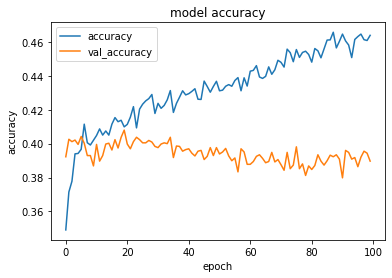

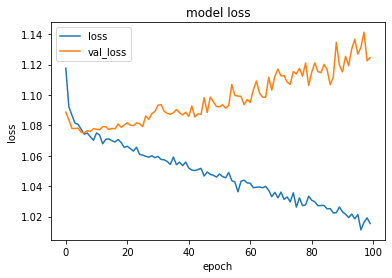

In [49]:
# list all data in history       
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
fig_path = 'accuracy_history.png'
plt.savefig(fig_path)     
plt.show()

# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
fig_path = 'loss_history.png'
plt.savefig(fig_path) 
plt.show()

In [50]:
# BUY | SELL | HOLD

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
y_test_enc = encode_categ_data(y_test)
for i in y_test_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

In [51]:
print(y_pred[10:20])
print(y_test_enc[10:20])

[[0.32667026 0.32729664 0.34603307]
 [0.27551067 0.37174988 0.35273945]
 [0.31503218 0.3404211  0.3445467 ]
 [0.30419546 0.3527284  0.34307614]
 [0.34433877 0.30750242 0.3481588 ]
 [0.3383563  0.3121173  0.34952644]
 [0.3613174  0.27064362 0.36803898]
 [0.2819409  0.37929946 0.3387597 ]
 [0.27345133 0.3867648  0.33978388]
 [0.31885606 0.3427088  0.33843508]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [52]:
print(pred_array[10:20])
print(real_array[10:20])

[2 1 2 1 2 2 2 1 1 1]
[0 0 0 1 2 1 0 1 0 0]


In [53]:
accuracy_score_DNN = accuracy_score(real_array, pred_array)
print('Accuracy Score - DL: ', accuracy_score_DNN)

Accuracy Score - DL:  0.401190704820434


In [54]:
print(classification_report(real_array, pred_array))

              precision    recall  f1-score   support

           0       0.40      0.20      0.27      1746
           1       0.45      0.48      0.46      1757
           2       0.37      0.53      0.43      1704

    accuracy                           0.40      5207
   macro avg       0.40      0.40      0.39      5207
weighted avg       0.40      0.40      0.39      5207



In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(real_array, pred_array)
confusion_matrix

array([[357, 531, 858],
       [235, 836, 686],
       [310, 498, 896]], dtype=int64)

In [56]:
weightedFScore_DNN = weightedFScore(confusion_matrix)[0] 
weightedFScore_DNN

0.5981028339507775

<AxesSubplot:>

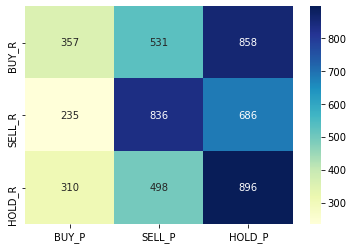

In [57]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_DNN = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_DNN, annot=True, fmt='d', cmap='YlGnBu')

In [58]:
y_pred_train = model_dnn.predict(x_train)

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred_train:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
for i in y_train_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(real_array, pred_array)))

Training-set accuracy score: 0.4990


# LSTM

In [39]:
# define and fit the final model
timer = Timer()
timer.start()
timesteps = configs['dataset']['sequence_length']

model_lstm = Sequential()

model_lstm.add(LSTM(200, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(150, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, input_shape=(timesteps, dim), return_sequences=False))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(3, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
print(model_lstm.summary())
timer.stop()


[model] Model Compiled
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50, 200)           207200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50, 150)           210600    
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 150)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 100)           100400    
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_8 (LSTM)                (N

In [40]:
timer = Timer()
timer.start()
print('[Model] Training Started')

save_dir=configs['model']['save_dir']
my_model=configs['model']['model_name']
save_fname = os.path.join(save_dir, '%s_LSTM_activTanh.h5' % my_model)

batch_size=configs['training']['batch_size']

callbacks = [ ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]

y_train_sw_enc = encode_categ_data(y_train_sw)
y_valid_sw_enc = encode_categ_data(y_valid_sw)
H = model_lstm.fit( x_train_sw, y_train_sw_enc, validation_data=(x_valid_sw, y_valid_sw_enc), epochs=5, 
                    batch_size=batch_size, callbacks=callbacks, workers=1 )

model_lstm.save(save_fname)

print('[Model] Training Completed.')
print('Model saved as %s' % save_fname)

timer.stop()

[Model] Training Started
['HOLD' 'BUY' 'BUY' 'HOLD' 'HOLD' 'HOLD' 'HOLD' 'SELL' 'HOLD' 'HOLD']
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]
['BUY' 'BUY' 'BUY' 'HOLD' 'HOLD' 'HOLD' 'HOLD' 'HOLD' 'HOLD' 'HOLD']
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Train on 7907 samples, validate on 4237 samples
Epoch 1/5
7907/7907 [==============================] - 37s 5ms/step - loss: 0.9444 - accuracy: 0.6098 - val_loss: 1.0437 - val_accuracy: 0.5228
Epoch 2/5
7907/7907 [==============================] - 33s 4ms/step - loss: 0.9311 - accuracy: 0.6157 - val_loss: 1.0434 - val_accuracy: 0.5228
Epoch 3/5
7907/7907 [==============================] - 33s 4ms/step - loss: 0.9287 - accuracy: 0.6154 - val_loss: 1.0433 - val_accuracy: 0.5225
Epoch 4/5
7907/7907 [==============================] - 33s 4ms/step - loss: 0.9249 - accuracy: 0.6140 - val_loss: 

In [41]:
# new instances where we do not know the answer
y_pred = model_lstm.predict(x_test_sw) 
y_pred

array([[0.30150884, 0.4499587 , 0.24853249],
       [0.2806711 , 0.46928084, 0.25004807],
       [0.21571672, 0.53359514, 0.2506881 ],
       ...,
       [0.2602117 , 0.5830988 , 0.15668942],
       [0.27707934, 0.5634354 , 0.15948528],
       [0.291933  , 0.5275594 , 0.18050762]], dtype=float32)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


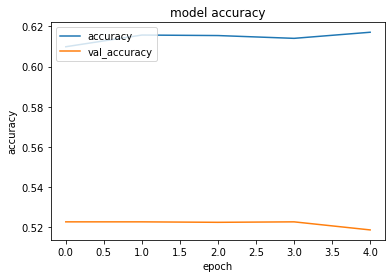

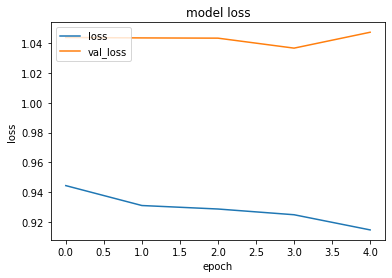

In [42]:
# list all data in history       
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
fig_path = 'accuracy_history.png'
plt.savefig(fig_path)     
plt.show()

# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
fig_path = 'loss_history.png'
plt.savefig(fig_path) 
plt.show()

In [162]:
# BUY | SELL | HOLD

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
y_test_sw_enc = encode_categ_data(y_test_sw)
for i in y_test_sw_enc:
    real.append(np.argmax(i))
real_array = np.array(real)   

In [163]:
print(y_pred[0:10])
print(pred_array[0:10])

[[0.30150884 0.4499587  0.24853249]
 [0.2806711  0.46928084 0.25004807]
 [0.21571672 0.53359514 0.2506881 ]
 [0.1682213  0.5803378  0.2514409 ]
 [0.15152529 0.59882766 0.24964713]
 [0.14222588 0.61134434 0.2464298 ]
 [0.1364296  0.62271696 0.24085347]
 [0.13735151 0.6454683  0.21718015]
 [0.1433439  0.64197385 0.21468225]
 [0.15242647 0.6344103  0.21316321]]
[1 1 1 1 1 1 1 1 1 1]


In [164]:
print(y_test_sw_enc[500:510])
print(real_array[500:510])

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
[2 1 1 1 1 2 1 0 0 0]


In [165]:
y_pred.shape

(4444, 3)

In [166]:
pred_array.shape

(4444,)

In [167]:
y_test_sw_enc.shape

(4444, 3)

In [168]:
real_array.shape

(4444,)

In [169]:
accuracy_score_LSTM = accuracy_score(real_array, pred_array)
print('Accuracy Score - LSTM: ', accuracy_score_LSTM)

Accuracy Score - LSTM:  0.5117011701170117


In [170]:
print(classification_report(real_array, pred_array))

              precision    recall  f1-score   support

           0       0.21      0.01      0.02      1100
           1       0.52      0.99      0.68      2286
           2       0.00      0.00      0.00      1058

    accuracy                           0.51      4444
   macro avg       0.24      0.33      0.23      4444
weighted avg       0.32      0.51      0.35      4444



In [171]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(real_array, pred_array)
confusion_matrix

array([[   9, 1087,    4],
       [  19, 2265,    2],
       [  15, 1043,    0]], dtype=int64)

In [172]:
real_array.sum()

4402

In [173]:
real_array.size

4444

In [174]:
pred_array.sum()

4407

In [175]:
pred_array.size

4444

In [49]:
weightedFScore_LSTM = weightedFScore(confusion_matrix)[0] 
weightedFScore_LSTM

0.2701878965459461

<AxesSubplot:>

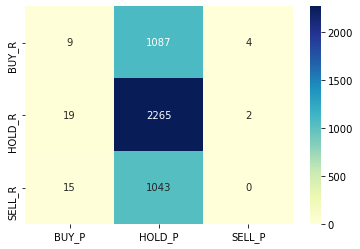

In [50]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_LSTM = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_LSTM, annot=True, fmt='d', cmap='YlGnBu')

In [51]:
y_pred_train_sw = model_lstm.predict(x_train_sw)

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred_train_sw:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
for i in y_train_sw_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

print('Training-set accuracy score LSTM: {0:0.4f}'. format(accuracy_score(real_array, pred_array)))

Training-set accuracy score LSTM: 0.6182


# Resumo

In [59]:
print('-------------Resumo-------------')

print('\nAccuracy Score - LGBM: ', accuracy_score_LGBM)
print('Weighted F Score - LGBM: ', weightedFScore_LGBM)

print('\nAccuracy Score - Random Forest: ', accuracy_score_RF)
print('Weighted F Score - Random Forest: ', weightedFScore_RF)

print('\nAccuracy Score - DNN: ', accuracy_score_DNN)
print('Weighted F Score - DNN: ', weightedFScore_DNN)




Accuracy Score - LGBM:  0.3981179181870559
Weighted F Score - LGBM:  0.5277089376661241

Accuracy Score - Random Forest:  0.39734972152871134
Weighted F Score - Random Forest:  0.5280326343079771

Accuracy Score - DNN:  0.401190704820434
Weighted F Score - DNN:  0.5981028339507775


<AxesSubplot:>

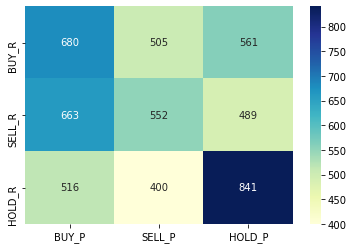

In [60]:
sns.heatmap(cm_matrix_LGBM, annot=True, fmt='d', cmap='YlGnBu')

<AxesSubplot:>

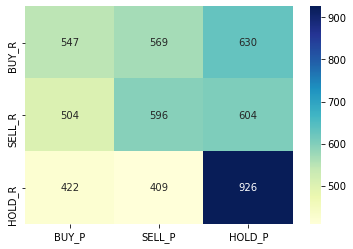

In [61]:
sns.heatmap(cm_matrix_RF, annot=True, fmt='d', cmap='YlGnBu')

<AxesSubplot:>

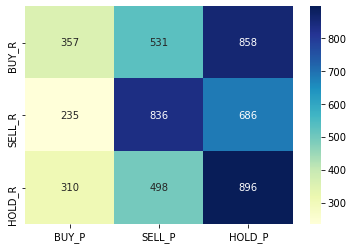

In [62]:
sns.heatmap(cm_matrix_DNN, annot=True, fmt='d', cmap='YlGnBu')

In [63]:
# save trained model
#pickle.dump( model_lgbm, open( 'saved_models/model_LGBM_53features_5000.pkl', 'wb' ) )

In [64]:
#pickle.dump( model_dnn, open( 'saved_models/model_DNN_53features_100.pkl', 'wb' ) )

In [65]:
#pickle.dump( model_randomF, open( 'saved_models/model_RF_53features_5000.pkl', 'wb' ) )